In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import wcs
import pickle

import sys
import imp
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils
imp.reload(cat_utils)
from scipy.optimize import curve_fit
import scipy

In [2]:
# LOAD LITERATURE IR POWER SPECTRA (Zemcov+ 14)

dat_dir = '../zemcov14_data/'
ell_Cell_ciber = np.genfromtxt(dat_dir+'zemcov14_CIBER_data_with_errors_Cl.txt',skip_header=4,delimiter=',')
ell_Cell_eormodel = np.genfromtxt(dat_dir+'zemcov14_eor_Cl.txt',skip_header=1,delimiter=',')

# these are in nW/m^2/sr, but I want to convert them to kJy/sr
# I have to divide by the bandwidth of 0.5um
lamda_m = 1.1e-6
freq_Hz = 3.e8/lamda_m
convert_to_kJy_per_sr = 1.e-9/freq_Hz/(1.e3*1.e-26)

ell_Cell_ciber[:,1] *= convert_to_kJy_per_sr
# ell_Cell_eormodel[:,1] *= convert_to_kJy_per_sr

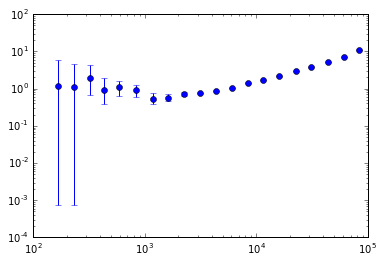

In [3]:
plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1]),\
                                                                 np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])],fmt='o')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [4]:
# label_groups = [ \
# '02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I', \
# '02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I',\
# '02a57694o0301I 02a57694o0305I 02a57694o0309I 02a57694o0321I 02a57694o0325I 02a57694o0329I 02a57694o0341I 02a57694o0345I 02a57694o0349I',\
# '02a57694o0300I 02a57694o0304I 02a57694o0308I 02a57694o0320I 02a57694o0324I 02a57694o0328I 02a57694o0340I 02a57694o0344I 02a57694o0348I']

In [5]:
labels = '02a57694o0299I 02a57694o0303I 02a57694o0307I 02a57694o0319I 02a57694o0323I 02a57694o0327I 02a57694o0339I 02a57694o0343I 02a57694o0347I'.split()
# labels = '02a57694o0298I 02a57694o0302I 02a57694o0306I 02a57694o0318I 02a57694o0322I 02a57694o0326I 02a57694o0338I 02a57694o0342I 02a57694o0346I'.split()
analysis_name = '_'.join([l.split('o')[1] for l in labels])
print(analysis_name)

run = 'ATLAS_mwa57694_rereduction'
xcor_data_dir = '/home/abrahamn/xcor_data/'
raw_frames_root = xcor_data_dir+run+'/'
analysis_root = xcor_data_dir+'analysis/'+run+'/' + analysis_name + '/'

0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I


In [6]:
# secat = pickle.load( open('/Users/abrahamn/Documents/MIT/21cm/21cmIR/ir_catalogs/whole_field_secat.p', "rb" ) )
# g = secat.jy>1.e-10
# secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

# srcdat = np.genfromtxt(raw_frames_root+labels[0]+'.dph')
# dphcat = cat_utils.Catalog(srcdat[:,0],srcdat[:,1],3631*10.**(-srcdat[:,2]/2.5))

secat = cat_utils.IRCatalog(se_path=analysis_root+analysis_name+'.sex',se_magzpt=20.46)
g = secat.jy_all>1.e-10
secat = cat_utils.Catalog(secat.ra_all[g],secat.dec_all[g],secat.jy_all[g],a=secat.a[g],b=secat.b[g])

loading/home/abrahamn/xcor_data/analysis/ATLAS_mwa57694_rereduction/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I/0299I_0303I_0307I_0319I_0323I_0327I_0339I_0343I_0347I.sex


In [7]:
# plt.figure(figsize=(14,12))
# plt.scatter(secat.ra,secat.dec,secat.jy*5000,facecolors='red',edgecolors='none')
# plt.scatter(dphcat.ra,dphcat.dec,dphcat.jy*5000,facecolors='none')

# plt.xlim([-2,-1])
# plt.ylim([-31,-30])

In [8]:
img_fits_path = analysis_root+analysis_name+'.fits'

hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()

x,y = np.where(img != 0)
x_med, y_med = np.median(x),np.median(y)

In [9]:
# regfiletest = open(analysis_root+'regfiletest.reg','w')

# regfiletest.write('# Region file format: DS9 version 4.1\n')
# regfiletest.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
# regfiletest.write('icrs\n')

# radmin,radmax = 7.5,60
# logjymin,logjymax = -5,0
# def rad_asec_for_jy(jy):
#     return jy*25+(radmax-radmin)/(logjymax-logjymin)*(np.log10(jy)-logjymin)+radmin
# def rad_asec_for_jy_old(jy):
#     radmax=40
#     return jy*15+(radmax-radmin)/(logjymax-logjymin)*(np.log10(jy)-logjymin)+radmin
# secat_rad = rad_asec_for_jy(secat.jy)

# for i in range(len(secat.jy)):
#     regfiletest.write("circle(%f,%f,%f\")\n"%(secat.ra[i],secat.dec[i],secat_rad[i]))
                                              

# regfiletest.close()

In [10]:
# #hi = plt.hist(np.log10(secat.jy),np.linspace(-5,0),histtype='step',color='blue')
# # hi = plt.hist(np.log10(srcjy),np.linspace(-5,0),histtype='step',color='red')
# hi = plt.hist(np.log10(secat.jy),np.linspace(-5,2),histtype='step',color='cyan')
# plt.gca().set_yscale('log')

In [11]:
# logjyvals = np.linspace(-5,2,200)
# plt.plot(logjyvals,np.log10(rad_asec_for_jy(10.**logjyvals)))
# plt.plot(logjyvals,np.log10(rad_asec_for_jy_old(10.**logjyvals)))

In [12]:
img_fits_path = analysis_root+analysis_name+'.fits'
hdulist_img = fits.open(img_fits_path)
img = hdulist_img[0].data
h = hdulist_img[0].header
n = img.shape[0]
hdulist_img.close()

w = wcs.WCS(h)
mask = np.ones(img.shape)
asec_per_pixel = np.abs(h['CD1_1'])*3600

In [13]:
def mask_circle_in_image(m,xcent,ycent,r):
    n=m.shape[0]
    if not ((0<=xcent<n) and (0<=ycent<n)): return
    for y in range(-int(r),int(r)+1): # x is the x distance from circle center
        if not (0 <= ycent+y < n): continue
        #print(n)
        #print(int(xcent-np.sqrt(r**2-y**2)),int(xcent+np.sqrt(r**2-y**2)))
        #rint(max(0,int(xcent-np.sqrt(r**2-y**2))),min(n,int(xcent+np.sqrt(r**2-y**2))),)
        m[ycent+y,max(0,int(xcent-np.sqrt(r**2-y**2))):min(n,int(xcent+np.sqrt(r**2-y**2)))] = 0


In [14]:
px,py = w.wcs_world2pix(secat.ra,secat.dec,1)

mask_coef1 = 15
mask_coef2 = 16


# draw a filled circle of zeros on the mask image for each source
for i in range(len(secat.ra)):
    if i % 2500 == 0: print(1.*i/len(secat.ra))
    #mask_circle_in_image(mask,px[i],py[i],secat_rad[i]/asec_per_pixel)
    mask_circle_in_image(mask,px[i],py[i],mask_coef1*secat.jy[i]/asec_per_pixel+mask_coef2*min(secat.a[i],secat.b[i]))

0.0


/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0490975863627
0.0981951727253
0.147292759088
0.196390345451
0.245487931813
0.294585518176
0.343683104539
0.392780690901
0.441878277264
0.490975863627
0.540073449989
0.589171036352
0.638268622715
0.687366209077
0.73646379544
0.785561381802
0.834658968165
0.883756554528
0.93285414089
0.981951727253


In [15]:
mask *= img<10+np.median(img[img>0])

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


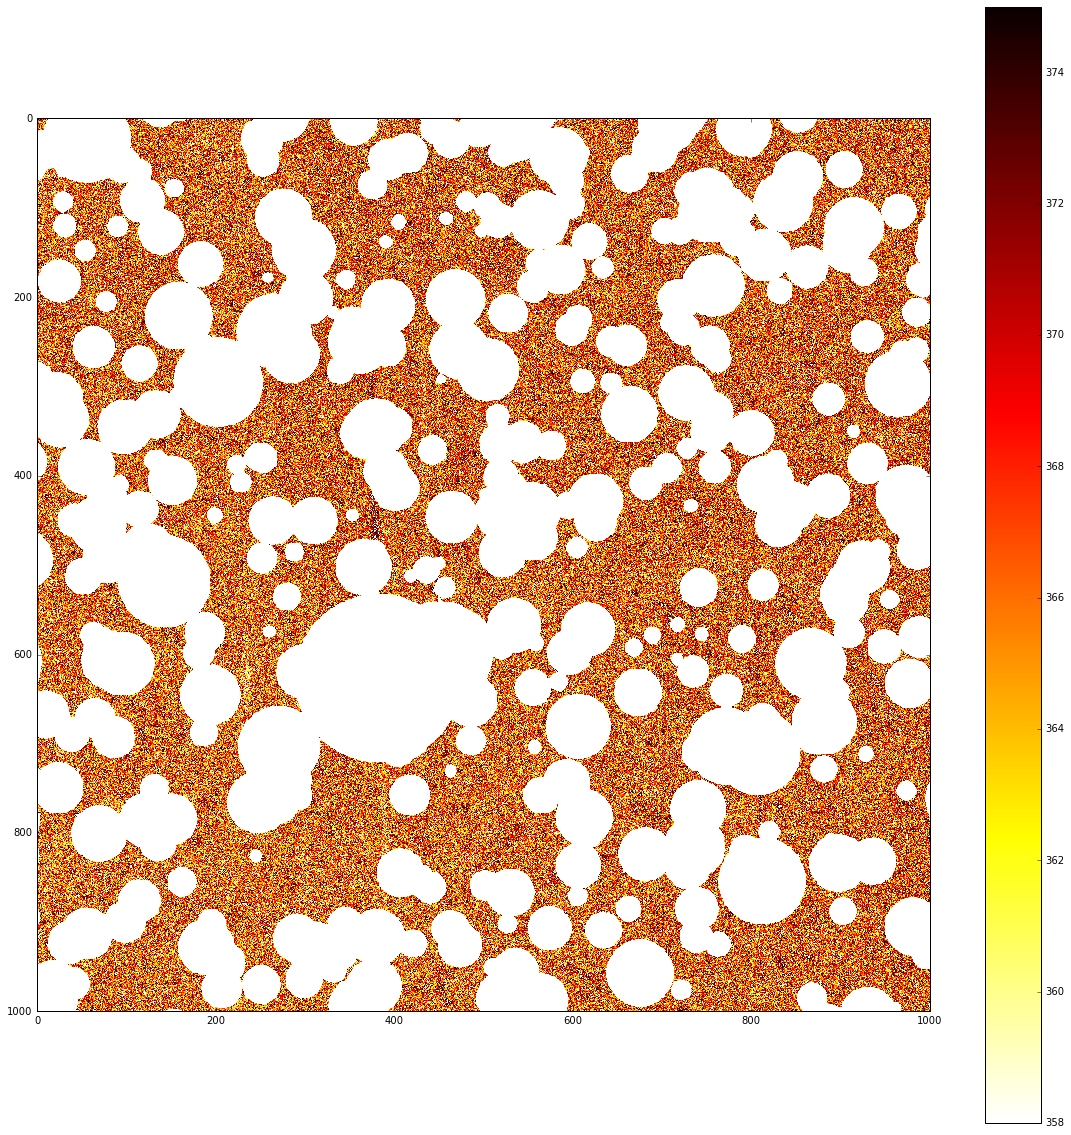

In [16]:
plt.figure(figsize=(20,20))

# x0,x1 = 6400,7000
# y0,y1 = 15200,15800
# x0,x1 = 2400,12000
# y0,y1 = 10400,22600
v0,v1 = 358,375
dd = 500
x0,x1 = x_med-dd,x_med+dd
y0,y1 = y_med-dd,y_med+dd
skip=1

# plt.subplot(121)
# plt.imshow(img[x0:x1:skip,y0:y1:skip],vmin=v0,vmax=v1,cmap='hot_r',interpolation='nearest')
# plt.colorbar()

#plt.subplot(122)
plt.imshow(img[x0:x1:skip,y0:y1:skip]*mask[x0:x1:skip,y0:y1:skip],vmin=v0,vmax=v1,cmap='hot_r',interpolation='nearest')
plt.colorbar()

In [17]:
target_coarse_res_asec = 4.5*60
fine_pixel_asec = 1.86
coarse_bin_factor = int(np.round(target_coarse_res_asec/fine_pixel_asec))
print(coarse_bin_factor)
dtheta_coarse_rad = fine_pixel_asec*coarse_bin_factor/3600*np.pi/180

n_coarse = int(np.floor(1.*n/coarse_bin_factor))
n_fine_max = n_coarse*coarse_bin_factor
print(n_coarse,coarse_bin_factor)

145
(160, 145)


In [18]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [19]:
def bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,min_fraction_unmasked=.5,gauss_fit_min=.1):

    img_binned_fitunmasked = np.zeros((n_coarse,n_coarse))
    img_binned_counts = np.zeros((n_coarse,n_coarse))

    binedges = np.linspace(300,400,200)
    for i in range(n_coarse):
        if i % 15 == 0: print(1.*i/n_coarse)
        for j in range(n_coarse):
            img_in_this_coarse_bin = img[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            mask_in_this_coarse_bin = mask[i*coarse_bin_factor:(i+1)*coarse_bin_factor,j*coarse_bin_factor:(j+1)*coarse_bin_factor]
            if np.any(img_in_this_coarse_bin==0) or np.sum(mask_in_this_coarse_bin)<min_fraction_unmasked*coarse_bin_factor**2: continue

            img_binned_counts[i,j] = np.sum(mask_in_this_coarse_bin)

    #         unmasked_vals_in_this_coarse_bin = img_in_this_coarse_bin[1==mask_in_this_coarse_bin]
    #         g = unmasked_vals_in_this_coarse_bin<np.percentile(unmasked_vals_in_this_coarse_bin,99)
    #         img_binned_avgunmasked[i,j] = np.mean(unmasked_vals_in_this_coarse_bin[g])

            counts,binedges = np.histogram(img_in_this_coarse_bin[1==mask_in_this_coarse_bin].flatten(),binedges)
            bins = .5*(binedges[1:]+binedges[:-1])
            g = counts>np.max(counts)*gauss_fit_min

            try:
                coeff, var_matrix = curve_fit(gauss, bins[g], counts[g],\
                                              p0=[np.max(counts),np.median(img_in_this_coarse_bin[1==mask_in_this_coarse_bin]),10],\
                                              sigma=np.sqrt(counts[g]))
                img_binned_fitunmasked[i,j] = coeff[1]
            except:
                pass
    return img_binned_fitunmasked

img_binned_fitunmasked = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,.5,.05)
img_binned_fitunmasked3 = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,.5,.25)

img_binned_fitunmasked4 = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,.1,.05)
img_binned_fitunmasked6 = bin_image_with_mask(img,mask,n_coarse,coarse_bin_factor,.1,.25)

0.0


/home/abrahamn/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.09375
0.1875
0.28125
0.375
0.46875
0.5625
0.65625
0.75
0.84375
0.9375
0.0
0.09375
0.1875
0.28125
0.375
0.46875
0.5625
0.65625
0.75
0.84375
0.9375
0.0
0.09375
0.1875
0.28125
0.375
0.46875
0.5625
0.65625
0.75
0.84375
0.9375
0.0
0.09375
0.1875
0.28125
0.375
0.46875
0.5625
0.65625
0.75
0.84375
0.9375


53


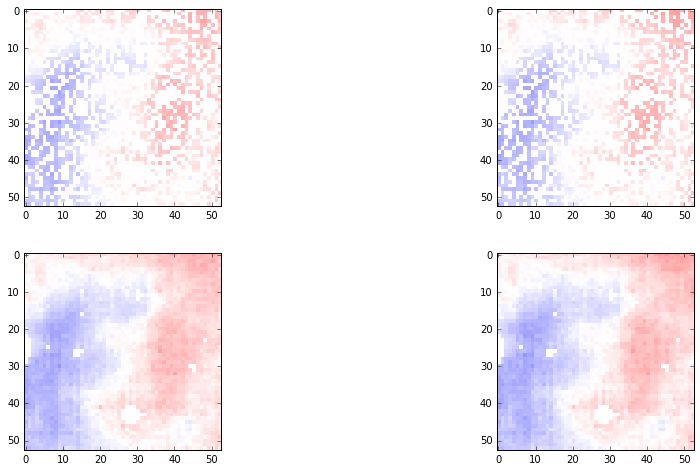

In [20]:
# so now let's use the inverse variance weighted power spectrum estimator,
# and compare it to the FFT power spectrum

fov_deg = 4.
d = int(fov_deg*np.pi/180/dtheta_coarse_rad)
print(d)

dtheta_rad = 1.86/3600*np.pi/180
x0 = int(x_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
x1 = x0+d
y0 = int(y_med*dtheta_rad/dtheta_coarse_rad-d/2+1)
y1 = y0+d

magzpt = 20.56
exp_time_sec = 30

conv = 3.631*(10**(-magzpt/2.5))/exp_time_sec/dtheta_coarse_rad**2*coarse_bin_factor**2

def add_units_and_meansub(img_binned):
    img_kjy_per_sr = conv*img_binned[x0:x1,y0:y1]
    img_kjy_per_sr_meansub = np.array(img_kjy_per_sr)
    img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0] -= np.mean(img_kjy_per_sr_meansub[img_kjy_per_sr_meansub!=0])
    return img_kjy_per_sr_meansub
    
img_kjy_per_sr_meansub = add_units_and_meansub(img_binned_fitunmasked)
img_kjy_per_sr_meansub3 = add_units_and_meansub(img_binned_fitunmasked3)
img_kjy_per_sr_meansub4 = add_units_and_meansub(img_binned_fitunmasked4)
img_kjy_per_sr_meansub6 = add_units_and_meansub(img_binned_fitunmasked6)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(img_kjy_per_sr_meansub,interpolation='nearest',vmin=-100,vmax=100,cmap='seismic')

plt.subplot(233)
plt.imshow(img_kjy_per_sr_meansub3,interpolation='nearest',vmin=-100,vmax=100,cmap='seismic')

plt.subplot(234)
plt.imshow(img_kjy_per_sr_meansub4,interpolation='nearest',vmin=-100,vmax=100,cmap='seismic')

plt.subplot(236)
plt.imshow(img_kjy_per_sr_meansub6,interpolation='nearest',vmin=-100,vmax=100,cmap='seismic')

In [21]:
from numpy import sqrt,matrix,transpose,array,fft,pi,zeros,meshgrid,random,linspace,arange,where,exp,conj,real,trace
from scipy.linalg import sqrtm,inv

/home/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


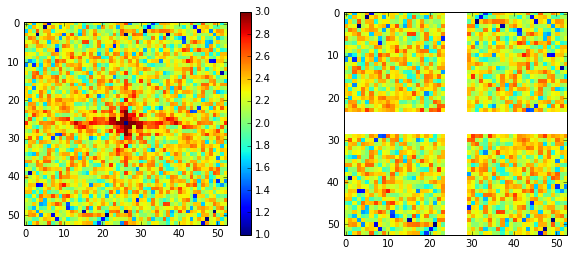

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft2(img_kjy_per_sr_meansub)))),interpolation='nearest',vmin=1,vmax=3)
plt.colorbar()

lvals = np.fft.fftfreq(img_kjy_per_sr_meansub.shape[0])*2*np.pi/dtheta_rad
lx,ly = meshgrid(lvals,lvals)
dl = np.abs(lvals[1]-lvals[0])

plt.subplot(122)
plt.imshow(np.log10(np.fft.fftshift(np.abs(fft.fft2(img_kjy_per_sr_meansub)))*fft.fftshift((np.abs(lx)>2*dl)&(np.abs(ly)>2*dl))),interpolation='nearest',vmin=1,vmax=3)

In [23]:
def make_hann_2D(n):
    w = scipy.signal.hann(n)
    wx,wy = np.meshgrid(w,w)
    w2 = wx*wy
    return w2, sqrt(np.mean(w2**2))

def make_bins(lmin,lmax,nbins,uselogbins):
    if uselogbins: 
        lbinedges = 10.**linspace(np.log10(lmin),np.log10(lmax),nbins+1)
    else:
        lbinedges = linspace(lmin,lmax,nbins+1)
    lbincenters = .5*(lbinedges[0:nbins]+lbinedges[1:nbins+1])
    return lbincenters,lbinedges

def vec2arr(v):
    return np.array(v).flatten()

def img2PS(img,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,filt_small_lx_and_ly_bins=False):
    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins)

    n = img.shape[0]
    lvals = fft.fftfreq(n)*2*np.pi/dtheta_rad
    lx,ly = meshgrid(lvals,lvals)
    dl = np.abs(lvals[1]-lvals[0])
    lmag  = sqrt(lx**2+ly**2)
    print(np.max(lmag))

    wind,windrms = np.ones((n,n)),1
    if usehann: wind,windrms = make_hann_2D(n)
    img_ft = fft.fft2((img-img.mean())*wind)/windrms
    
    pspec_binned = np.zeros(nbins)

    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (lmag>lbinedges[bini])&(lmag<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lx)>2*dl)&(np.abs(ly)>2*dl)
        bin_counts[bini] = np.sum(inbin)

        pspec_binned[bini] = np.mean(np.abs(img_ft[inbin])**2)

    pspec_norm = (dtheta_rad**2)/(n**2)
    return lbincenters,pspec_binned*pspec_norm,bin_counts

def img2optPS(img_meas,pguess,dtheta_rad,nbins,lmin,lmax,uselogbins=True,usehann=True,interp_pguess=False,verbose=False,filt_small_lx_and_ly_bins=False):
    n = img_meas.shape[0]
    norm = (dtheta_rad**2)/(n**2)*n**4
    xir = matrix(img_meas.flatten()).T

    lbincenters,lbinedges = make_bins(lmin,lmax,nbins,uselogbins=uselogbins)

    lvals = fft.fftfreq(n)*2*pi/dtheta_rad # ell values
    dl = np.abs(lvals[1]-lvals[0])
    print('\ndl = %d'%(lvals[1]-lvals[0]))
    lxgrid,lygrid = meshgrid(lvals,lvals)
    lmaggrid = sqrt(lxgrid**2+lygrid**2)

    if verbose:
        for bini in range(nbins):
            if filt_small_lx_and_ly_bins:
                smallell = (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])&smallell),lbincenters[bini]))
            else:
                print('%d cells in \ell=%1.1f bin'%(np.sum((lbinedges[bini]<lmaggrid)&(lmaggrid<lbinedges[bini+1])),lbincenters[bini]))
    
    thvals = (arange(n)-n/2)*dtheta_rad # theta values
    thxgrid,thygrid = meshgrid(thvals,thvals)
    
    def gen_Ccommabini(bini):
        inbin = (lmaggrid>=lbinedges[bini])*(lmaggrid<lbinedges[bini+1])
        if filt_small_lx_and_ly_bins: inbin &= (np.abs(lxgrid)>2*dl)&(np.abs(lygrid)>2*dl)
        ivals_inbin,jvals_inbin = where(inbin)

        lxvals,thxvals = meshgrid(lxgrid[ivals_inbin,jvals_inbin],thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid[ivals_inbin,jvals_inbin],thygrid.flatten()) # ell_y and theta_y
        Ccommabini_0 = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))
        Ccommabini = Ccommabini_0*conj(Ccommabini_0.T)
        return Ccommabini
    #Ccomma_mats = [gen_Ccommabini(bini) for bini in range(nbins)]


    # put in a guess of the data covariance
    if interp_pguess:
        print('a')
        # generate the fourier transform matrix
        lxvals,thxvals = meshgrid(lxgrid.flatten(),thxgrid.flatten()) # ell_x and theta_x
        lyvals,thyvals = meshgrid(lygrid.flatten(),thygrid.flatten()) # ell_y and theta_y
        F = matrix(exp(1j*(lxvals*thxvals+lyvals*thyvals)))/n**2
        Cguess_ft = matrix(np.diag( np.interp(lmaggrid.flatten(),lbincenters,pguess/norm/n**2) ))   
        Csignal = F*Cguess_ft*conj(F).T
    else:
        print('b')
        Csignal = np.matrix(np.zeros((n**2,n**2),dtype=complex))
        for bini in range(nbins):
            Csignal += pguess[bini]/norm/n**2*gen_Ccommabini(bini)
            
    print('c')
    Cmask = 1.e7*np.matrix(np.diag(img_meas.flatten()==0)) # IS THIS A REASONABLE NUMBER ??
    print('d')
    Cinv = inv(Csignal + Cmask)

    print('e')
    # calculate q_alpha
    q = np.matrix(np.zeros((nbins,1)))
    Ccomma_times_Cinv_mats = []
    print('bins: '),
    for bini in range(nbins):
        print(bini),
        Ccommabini_times_Cinv = gen_Ccommabini(bini)*Cinv
        Ccomma_times_Cinv_mats.append(Ccommabini_times_Cinv)
        q[bini] = .5*real(xir.T*Cinv*Ccommabini_times_Cinv*xir).item()

    # calculate Fisher matrix

    Fish = np.matrix(np.zeros((nbins,nbins)))
    print('\nfisher row: '),
    for i in range(nbins):
        print(i),
        for j in range(i,nbins):
            Fish[i,j] = np.real(.5*trace(Ccomma_times_Cinv_mats[i]*Ccomma_times_Cinv_mats[j]))
            Fish[j,i] = Fish[i,j]
    
    p0 = vec2arr(sqrtm(inv(Fish))*q)*norm/vec2arr(np.max(sqrt(Fish),axis=0))
    p1 = vec2arr(inv(Fish)*q*norm)

    return lbincenters,p0,p1,Fish

In [24]:
lmin,lmax = 350,3300
nbins = 6

lbins,pspec_m_h_lfilt,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
                                  uselogbins=True,usehann=True)
# lbins,pspec_m,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
#                                   uselogbins=True,usehann=False)
# lbins,pspec_m_lfilt,bin_counts = img2PS(img_kjy_per_sr_meansub,dtheta_coarse_rad,nbins,lmin,lmax,\
#                                   uselogbins=True,usehann=False,filt_small_lx_and_ly_bins=True)

# pguess = np.ones(nbins)
pguess = 1./lbins**2

# lbins,p0,p1,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
#                                                      uselogbins=True,usehann=True,interp_pguess=True,verbose=True)

lbins,p0_lfilt,p1_lfilt,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
                                                     uselogbins=True,usehann=True,interp_pguess=True,verbose=True,filt_small_lx_and_ly_bins=True)


lbins,p0_lfilt3,p1_lfilt3,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub3,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
                                                     uselogbins=True,usehann=True,interp_pguess=True,verbose=True,filt_small_lx_and_ly_bins=True)

lbins,p0_lfilt4,p1_lfilt4,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub4,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
                                                     uselogbins=True,usehann=True,interp_pguess=True,verbose=True,filt_small_lx_and_ly_bins=True)


lbins,p0_lfilt6,p1_lfilt6,Fish_l0_interp = img2optPS(img_kjy_per_sr_meansub6,pguess,dtheta_coarse_rad,nbins,lmin,lmax,\
                                                     uselogbins=True,usehann=True,interp_pguess=True,verbose=True,filt_small_lx_and_ly_bins=True)

3333.77688681

dl = 90
12 cells in \ell=429.4 bin
64 cells in \ell=624.1 bin
156 cells in \ell=907.1 bin
384 cells in \ell=1318.4 bin
876 cells in \ell=1916.2 bin
808 cells in \ell=2785.2 bin
a
c
d
e
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
dl = 90
12 cells in \ell=429.4 bin
64 cells in \ell=624.1 bin
156 cells in \ell=907.1 bin
384 cells in \ell=1318.4 bin
876 cells in \ell=1916.2 bin
808 cells in \ell=2785.2 bin
a
c
d
e
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
dl = 90
12 cells in \ell=429.4 bin
64 cells in \ell=624.1 bin
156 cells in \ell=907.1 bin
384 cells in \ell=1318.4 bin
876 cells in \ell=1916.2 bin
808 cells in \ell=2785.2 bin
a
c
d
e
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5 
dl = 90
12 cells in \ell=429.4 bin
64 cells in \ell=624.1 bin
156 cells in \ell=907.1 bin
384 cells in \ell=1318.4 bin
876 cells in \ell=1916.2 bin
808 cells in \ell=2785.2 bin
a
c
d
e
bins:  0 1 2 3 4 5 
fisher row:  0 1 2 3 4 5


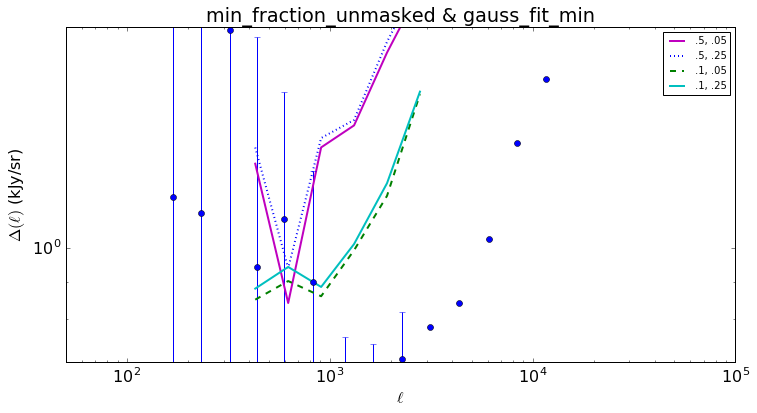

In [25]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,6))

#plt.loglog(lbins,sqrt(lbins**2*p0/(2*pi)),'r-',label='Pguess = 1, interp, p0',linewidth=2)
plt.loglog(lbins,sqrt(lbins**2*p0_lfilt/(2*pi)),'m-',label='.5, .05',linewidth=2)
plt.loglog(lbins,sqrt(lbins**2*p0_lfilt3/(2*pi)),'b:',label='.5, .25',linewidth=2)
plt.loglog(lbins,sqrt(lbins**2*p0_lfilt4/(2*pi)),'g--',label='.1, .05',linewidth=2)
plt.loglog(lbins,sqrt(lbins**2*p0_lfilt6/(2*pi)),'c-',label='.1, .25',linewidth=2)
plt.title('min_fraction_unmasked & gauss_fit_min')

# plt.loglog(lbins,sqrt(lbins**2*pspec_m/(2*pi)),'yo',label='FFT')
# plt.loglog(lbins,sqrt(lbins**2*pspec_m_lfilt/(2*pi)),'co',label='FFT, lfilt')
# plt.loglog(lbins,sqrt(lbins**2*pspec_m_h_lfilt/(2*pi)),'k-',label='FFT, lfilt, hann')

#plt.loglog(lbins,sqrt(lbins**2*pspec_m_h/(2*pi)),'mo',label='FFT+hann')
plt.errorbar(ell_Cell_ciber[1::3,0],ell_Cell_ciber[1::3,1],yerr=[np.abs(ell_Cell_ciber[1::3,1]-ell_Cell_ciber[0::3,1]),\
                                                                 np.abs(ell_Cell_ciber[2::3,1]-ell_Cell_ciber[1::3,1])],fmt='o')
           
plt.legend(fontsize=10)
plt.xlim([50,1.e5])
plt.ylim([.7,2])
plt.xlabel('$\ell$')
plt.ylabel('$\Delta(\ell)$ (kJy/sr)')
plt.savefig('pspec_study_%d_%d.png'%(mask_coef1,mask_coef2),bbox_inches='tight')